In [1]:
! pip install yfinance

In [26]:
import yfinance as yahooFinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [4]:
goog = yahooFinance.Ticker("GOOG")

df = goog.history(period="max")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.487833,2.588839,2.387325,2.496292,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.512960,2.713729,2.500273,2.694573,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.755276,2.823193,2.712983,2.721690,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.767466,2.776422,2.576649,2.608991,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.611230,2.686860,2.584361,2.637103,184645512,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-06 00:00:00-04:00,177.228310,178.506869,177.008574,178.147278,14255800,0.0,0.0
2024-06-07 00:00:00-04:00,178.257157,179.216057,175.590178,175.750000,14716300,0.0,0.0
2024-06-10 00:00:00-04:00,176.449997,178.470001,174.380005,176.630005,17122200,0.2,0.0


In [15]:
data = df[['Open', 'High', 'Low', 'Close', 'Volume']].values


In [16]:
data

array([[2.48783287e+00, 2.58883888e+00, 2.38732531e+00, 2.49629235e+00,
        8.97427216e+08],
       [2.51296039e+00, 2.71372880e+00, 2.50027284e+00, 2.69457269e+00,
        4.58857488e+08],
       [2.75527566e+00, 2.82319344e+00, 2.71298279e+00, 2.72168994e+00,
        3.66857939e+08],
       ...,
       [1.76449997e+02, 1.78470001e+02, 1.74380005e+02, 1.76630005e+02,
        1.71222000e+07],
       [1.77720001e+02, 1.78389999e+02, 1.75440002e+02, 1.78190002e+02,
        1.44024000e+07],
       [1.79750000e+02, 1.82080002e+02, 1.77779999e+02, 1.79559998e+02,
        1.83602000e+07]])

In [18]:
def split_train_test(data,test_size):
    if type(test_size) == float and 0<test_size<1:
        test_size = data.shape[0]*test_size
    if test_size>data.shape[0]:
        raise ValueError
    test_size = int(test_size)
    return data[:-test_size], data[-test_size:]

In [240]:
data_ = data[-6*30:]
data_.shape

(180, 5)

In [241]:
future = 3
train_, test_= split_train_test(data_,future)
train_.shape, test_.shape

((177, 5), (3, 5))

In [242]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train_)
test_sc = sc.transform(test_)


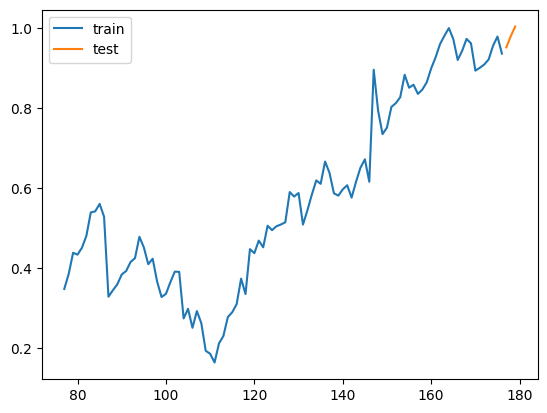

In [243]:
window = 21
idx = 3
rng = 100

index1 = np.arange(train_sc.shape[0])
index2 = np.arange(train_sc.shape[0],train_sc.shape[0]+test_sc.shape[0])


plt.plot(index1[-rng:],train_sc[-rng:,idx], label="train")
plt.plot(index2,test_sc[:,idx],label="test")
plt.legend()
plt.show()

In [246]:
def to_seq(data,window,future, idx=None):
    x, y, z, xx, zz = [],[],[],[],[]
    for i in range(data.shape[0]-window-future):
        x.append(data[i:i+window])
        if idx:
            y_ = data[i+window+future][idx:idx+1]
            z_ = data[i+window+future-1][idx:idx+1]
        else:
            y_ = data[i+window+future]
            z_ = data[i+window+future-1]
        y.append(y_)
        z.append(z_)
    for j in range(i+1,data.shape[0]-window ):
        xx.append(data[j:j+window])
    if idx:
        zz = [data[j+window][idx:idx+1]]
    else:
        zz = [data[j+window]]

    x, y, z, xx, zz = np.array(x), np.array(y), np.array(z), np.array(xx), np.array(zz)
    return x, y, z, xx, zz

In [247]:

x_trian, y_train, z_train, xx, zz = to_seq(train_sc,window=window,future=future,idx=idx)

In [248]:
x_trian.shape, y_train.shape, z_train.shape, xx.shape, zz.shape

((153, 21, 5), (153, 1), (153, 1), (3, 21, 5), (1, 1))

# modols

In [249]:
from keras.models import Model, Sequential
from keras.layers import Dense, Concatenate, ConvLSTM1D, InputLayer,Reshape, Flatten, ConvLSTM2D

In [291]:
model_1 = Sequential(name="Conv_lstm")
model_1.add(InputLayer(x_trian.shape[1:], name="Input_all_price"))
model_1.add(Reshape((1,)+x_trian.shape[1:], name="reshape_layer1"))

model_1.add(ConvLSTM1D(512,6,activation="tanh", return_sequences=True, name="ConvLSTM_layer1"))
model_1.add(ConvLSTM1D(256,5,activation="tanh", return_sequences=True, name="ConvLSTM_layer2"))
model_1.add(ConvLSTM1D(64,4,activation="tanh",return_sequences=True, name="ConvLSTM_layer3"))
model_1.add(ConvLSTM1D(32,3,activation="tanh",return_sequences=False, name="ConvLSTM_layer4"))
model_1.add(Flatten(name="Flatten_layer"))
model_1.add(Dense(512,activation="tanh", name="Linear_layer1"))
model_1.add(Dense(128,activation="tanh", name="Linear_layer2"))
model_1.add(Dense(10,activation="tanh", name="Linear_layer3"))

model_2 = Sequential(name="use_last_price")
model_2.add(InputLayer((1,),  name="Input_last_price"))
model_2.add(Dense(1,activation="tanh", name="Linear_layer1_last_price"))

concat = Concatenate(name="Concat_layer")([model_1.output,model_2.output])
output = Dense(1,activation="tanh",name="Predict_layer")(concat)
model = Model(inputs=[model_1.input,model_2.input], outputs=output)

model.compile(optimizer="adam", loss="mse")

In [292]:
from keras.utils import plot_model

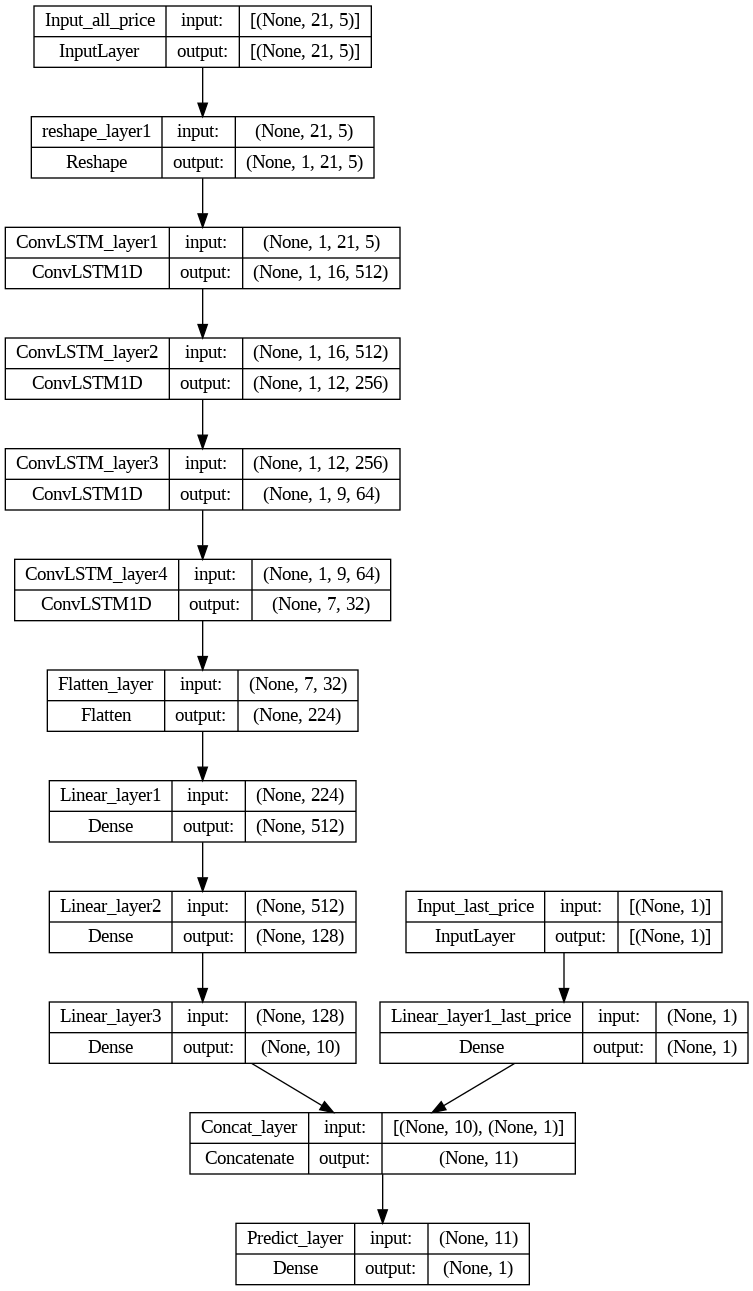

In [293]:
plot_model(model,to_file="model.png",show_shapes=True  )

In [294]:
history = model.fit([x_trian,z_train], y_train, epochs=100)

Epoch 1/100
5/5 [==============================] - 19s 1s/step - loss: 0.6442
Epoch 2/100
5/5 [==============================] - 6s 1s/step - loss: 0.1393
Epoch 3/100
5/5 [==============================] - 6s 1s/step - loss: 0.1738
Epoch 4/100
5/5 [==============================] - 5s 1s/step - loss: 0.1312
Epoch 5/100
5/5 [==============================] - 7s 1s/step - loss: 0.1160
Epoch 6/100
5/5 [==============================] - 5s 1s/step - loss: 0.0952
Epoch 7/100
5/5 [==============================] - 7s 1s/step - loss: 0.0748
Epoch 8/100
5/5 [==============================] - 6s 1s/step - loss: 0.0594
Epoch 9/100
5/5 [==============================] - 6s 1s/step - loss: 0.0498
Epoch 10/100
5/5 [==============================] - 7s 1s/step - loss: 0.0433
Epoch 11/100
5/5 [==============================] - 5s 1s/step - loss: 0.0418
Epoch 12/100
2/5 [===========>..................] - ETA: 3s - loss: 0.0435

KeyboardInterrupt: 

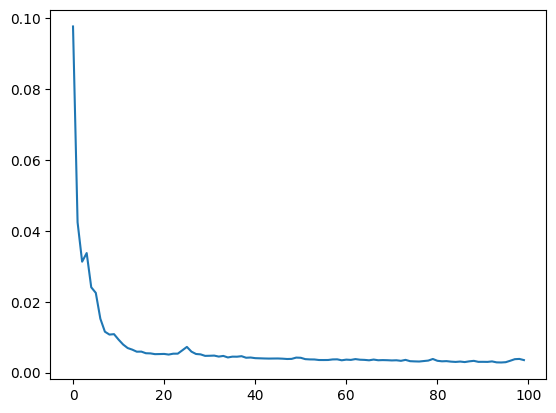

In [295]:
loss = history.history["loss"]
plt.plot(loss)
# plt.xticks(np.arange(len(loss)))
plt.show()

In [296]:
train_predict = model.predict([x_trian,z_train])

5/5 [==============================] - 4s 186ms/step


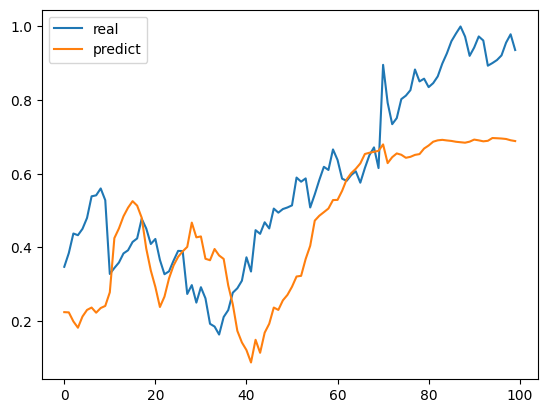

In [297]:
plt.plot(y_train[-100:], label="real")
plt.plot(train_predict[-100:], label='predict')
plt.legend()
plt.show()

In [298]:
def predict(x, z):
    x_shape = (1,)+ x.shape[1:]
    pre = []
    for i in range(x.shape[0]):
        xx = x[i]
        xx = xx.reshape(x_shape)
        z = model.predict([xx,z], verbose=False)
        pre.append(z.ravel())
    return np.array(pre)
test_predict = predict(xx,zz)

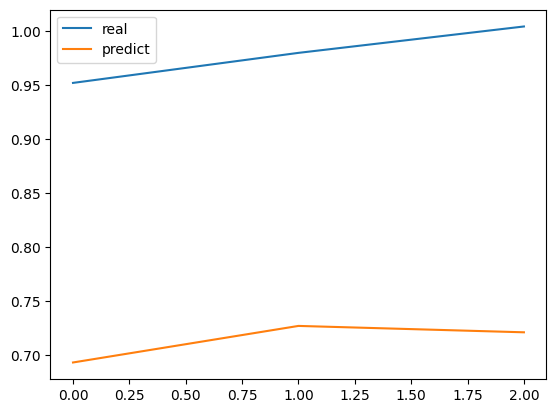

In [299]:
plt.plot(test_sc[:,3], label="real")
plt.plot(test_predict, label='predict')
plt.legend()
plt.show()